In [1]:
# 내장 라이브러리
import glob
import pathlib

# 외부 라이브러리
import pandas as pd
import pandas.io.formats.format as pf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import folium.plugins


pd.options.display.float_format = '{:0,.2f}'.format

sns.set_palette('husl')
sns.set_style('whitegrid')

plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False


DAY_OF_WEEK = ['월', '화', '수', '목', '금', '토', '일']
DAY_OF_WEEK_MAPPER = {i: day for i, day in enumerate(DAY_OF_WEEK)}
BASE_DIR = pathlib.Path('../').resolve()

CSV_FILES = glob.glob(str(BASE_DIR / '실습' / 'rawfiles' / 'CARD_SUBWAY_MONTH_*.csv'))

GEO_DATA_FILE = BASE_DIR / 'data' / '서울시행정구역경계구좌표.json'
SEOUL_LOCATION = [37.566345, 126.977893]

print('Files:\n'+'\n'.join(CSV_FILES)+'\n')

Files:
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201903.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201902.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201901.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201905.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201904.csv
/Users/hepheir/GitHub/smu-202115064/Training-project-for-AI-X-Pioneers-Basic/실습/rawfiles/CARD_SUBWAY_MONTH_201906.csv



In [2]:
def get_raw_df(files: list = CSV_FILES) -> pd.DataFrame:
    # 데이터를 병합하여 하나의 데이터프레임 형성
    return pd.concat([pd.read_csv(filename) for filename in files])


get_raw_df().info()

<class 'pandas.core.frame.DataFrame'>
Index: 107028 entries, 0 to 17723
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   사용일자    107028 non-null  int64  
 1   노선명     107028 non-null  object 
 2   역명      107028 non-null  object 
 3   승차총승객수  107028 non-null  float64
 4   하차총승객수  107028 non-null  float64
 5   등록일자    107028 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 5.7+ MB


## 역별 지리상 좌표 추가

In [3]:
def get_geoloc_raw_df() -> pd.DataFrame:
    df = pd.read_csv(BASE_DIR / "실습" / "rawfiles" / "지하철노선위경도정보2.csv")
    return df


print(get_geoloc_raw_df().info())
get_geoloc_raw_df()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   역이름     975 non-null    object 
 1   역지역     975 non-null    object 
 2   위도      975 non-null    float64
 3   경도      975 non-null    float64
 4   호선      975 non-null    object 
dtypes: float64(2), object(3)
memory usage: 38.2+ KB
None


,역이름,역지역,위도,경도,호선
0,낙성대,수도권,37.48,126.96,2호선
1,구룡,수도권,37.49,127.06,분당선
2,서울대입구,수도권,37.48,126.95,2호선
3,불광,수도권,37.61,126.93,3호선
4,월롱,수도권,37.80,126.79,경의선
...,...,...,...,...,...
970,현충원,대전,36.36,127.32,1호선
971,월드컵경기장,대전,36.37,127.32,1호선
972,노은,대전,36.37,127.32,1호선
973,지족,대전,36.38,127.32,1호선


In [4]:
def get_geoloc_df():
    df = get_geoloc_raw_df()
    df['노선명'] = df['호선']
    df['역명'] = df['역이름']
    del df['호선']
    del df['역이름']
    return df


get_geoloc_df()

,역지역,위도,경도,노선명,역명
0,수도권,37.48,126.96,2호선,낙성대
1,수도권,37.49,127.06,분당선,구룡
2,수도권,37.48,126.95,2호선,서울대입구
3,수도권,37.61,126.93,3호선,불광
4,수도권,37.80,126.79,경의선,월롱
...,...,...,...,...,...
970,대전,36.36,127.32,1호선,현충원
971,대전,36.37,127.32,1호선,월드컵경기장
972,대전,36.37,127.32,1호선,노은
973,대전,36.38,127.32,1호선,지족


## 역별 소속 지역구 조사

서울교통공사 역주소 및 전화번호를 토대로 각 역의 소속 지역을 조사해봅시다.

In [5]:
def get_addr_raw_df() -> pd.DataFrame:
    return pd.read_csv(BASE_DIR / 'data' / '서울교통공사 역주소 및 전화번호_20240331.csv')

print(get_addr_raw_df().info())

np.random.seed(0)
get_addr_raw_df().sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   연번          288 non-null    int64  
 1   역번호         288 non-null    int64  
 2   호선          288 non-null    int64  
 3   역명          288 non-null    object 
 4   역전화번호       288 non-null    object 
 5   Unnamed: 5  0 non-null      float64
 6   도로명주소       288 non-null    object 
 7   지번주소        288 non-null    object 
dtypes: float64(1), int64(3), object(4)
memory usage: 18.1+ KB
None


,연번,역번호,호선,역명,역전화번호,Unnamed: 5,도로명주소,지번주소
55,56,246,2,신설동,02-6110-1371,NaN,서울특별시 동대문구 왕산로 지하 1(신설동),서울특별시 동대문구 신설동 76-5 신설동역(2호선)
182,183,2617,6,새절(신사),02-6311-6161,NaN,서울특별시 은평구 증산로 지하400(신사동),서울특별시 은평구 신사동 337-5 새절역(6호선)
92,93,341,3,경찰병원,02-6110-3511,NaN,서울특별시 송파구 중대로 지하149(가락동),서울특별시 송파구 가락동 10-15 경찰병원역(3호선)
208,209,2643,6,상월곡(한국과학기술연구원),02-6311-6421,NaN,서울특별시 성북구 화랑로 지하157(상월곡동),서울특별시 성북구 상월곡동 26-1 상월곡역(6호선)
278,279,4129,9,봉은사,02-2656-0929,NaN,서울특별시 강남구 봉은사로 지하601(삼성동),서울특별시 강남구 삼성동 172 봉은사역(9호선)


In [6]:
def get_addr_df():
    df = get_addr_raw_df()

    # 정규표현식 Lookahead, Lookbehind 문법 사용
    # (https://ko.javascript.info/regexp-lookahead-lookbehind)
    df['지역(시)'] = df['지번주소'].str.extract(r'^(\w+시)(?=\s)')[0]
    df['지역(구)'] = df['지번주소'].str.extract(r'(?<=\s)(\w+구)(?=\s)')[0]
    df['지역(동)'] = df['지번주소'].str.extract(r'(?<=\s)(\w+동)(?=\s)')[0]

    # 정규표현식 Grouping 문법 사용
    df['부역명'] = df['역명'].str.extract(r'\w\((?P<TARGET>.*)\)$')['TARGET']
    df['역명'] = df['역명'].str.replace(r'\(\w+\)$', '', regex=True)

    del df['Unnamed: 5']
    del df['연번']
    del df['역전화번호']
    del df['도로명주소']
    return df


np.random.seed(0)
get_addr_df().sample(10)

,역번호,호선,역명,지번주소,지역(시),지역(구),지역(동),부역명
55,246,2,신설동,서울특별시 동대문구 신설동 76-5 신설동역(2호선),서울특별시,동대문구,신설동,NaN
182,2617,6,새절,서울특별시 은평구 신사동 337-5 새절역(6호선),서울특별시,은평구,신사동,신사
92,341,3,경찰병원,서울특별시 송파구 가락동 10-15 경찰병원역(3호선),서울특별시,송파구,가락동,NaN
208,2643,6,상월곡,서울특별시 성북구 상월곡동 26-1 상월곡역(6호선),서울특별시,성북구,상월곡동,한국과학기술연구원
278,4129,9,봉은사,서울특별시 강남구 삼성동 172 봉은사역(9호선),서울특별시,강남구,삼성동,NaN
45,236,2,영등포구청,서울특별시 영등포구 당산동3가 270-1 영등포구청역(2호선),서울특별시,영등포구,NaN,NaN
111,426,4,서울,서울특별시 용산구 동자동 14-151 서울역 (4호선),서울특별시,용산구,동자동,NaN
240,2736,7,고속터미널,서울특별시 서초구 반포동 19-11 고속터미널역(7호선),서울특별시,서초구,반포동,NaN
15,206,2,신당,서울특별시 중구 신당동 99 신당역(2호선),서울특별시,중구,신당동,NaN
22,213,2,구의,서울특별시 광진구 구의동 245-24 구의역(2호선),서울특별시,광진구,구의동,광진구청


## 지역별 인구수 데이터 가져오기

In [7]:
def get_pop_raw_df() -> pd.DataFrame:
    return pd.read_csv(str(BASE_DIR / 'data' / '등록인구_2019.csv'))

print(get_pop_raw_df().info())

np.random.seed(0)
get_pop_raw_df().head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1248 entries, 0 to 1247
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   시점      1248 non-null   object 
 1   동별(1)   1248 non-null   object 
 2   동별(2)   1248 non-null   object 
 3   구분별(1)  1248 non-null   object 
 4   구분별(2)  1248 non-null   object 
 5   데이터     1248 non-null   float64
dtypes: float64(1), object(5)
memory usage: 58.6+ KB
None


,시점,동별(1),동별(2),구분별(1),구분별(2),데이터
0,2019 1/4,합계,소계,세대 (세대),소계,"4,290,922.00"
1,2019 1/4,합계,소계,계 (명),소계,"10,054,979.00"
2,2019 1/4,합계,소계,계 (명),남자,"4,909,387.00"
3,2019 1/4,합계,소계,계 (명),여자,"5,145,592.00"
4,2019 1/4,합계,소계,한국인 (명),소계,"9,770,216.00"
5,2019 1/4,합계,소계,한국인 (명),남자,"4,772,134.00"
6,2019 1/4,합계,소계,한국인 (명),여자,"4,998,082.00"
7,2019 1/4,합계,소계,등록외국인 (명),소계,"284,763.00"
8,2019 1/4,합계,소계,등록외국인 (명),남자,"137,253.00"
9,2019 1/4,합계,소계,등록외국인 (명),여자,"147,510.00"


In [8]:
def get_pop_filtered_df() -> pd.DataFrame:
    df = get_pop_raw_df()
    df = df[df['동별(2)'] != '소계']
    df = df[df['구분별(1)'] == '계 (명)']
    df['지역(구)'] = df['동별(2)']
    df['성별'] = df['구분별(2)']
    df['인구수'] = df['데이터']
    del df['동별(1)']
    del df['동별(2)']
    del df['구분별(1)']
    del df['구분별(2)']
    del df['데이터']
    return df

np.random.seed(0)
get_pop_filtered_df().sample(10)

,시점,지역(구),성별,인구수
866,2019 3/4,동작구,남자,"198,593.00"
783,2019 3/4,서대문구,여자,"170,471.00"
61,2019 1/4,광진구,소계,"370,658.00"
915,2019 3/4,송파구,여자,"352,974.00"
999,2019 4/4,광진구,여자,"190,055.00"
566,2019 2/4,관악구,남자,"260,404.00"
963,2019 4/4,중구,여자,"69,665.00"
855,2019 3/4,영등포구,여자,"200,534.00"
218,2019 1/4,금천구,남자,"130,503.00"
457,2019 2/4,은평구,소계,"488,285.00"


지역별 인구수 데이터의 정규성을 확인해보자

<Axes: xlabel='인구수', ylabel='지역(구)'>

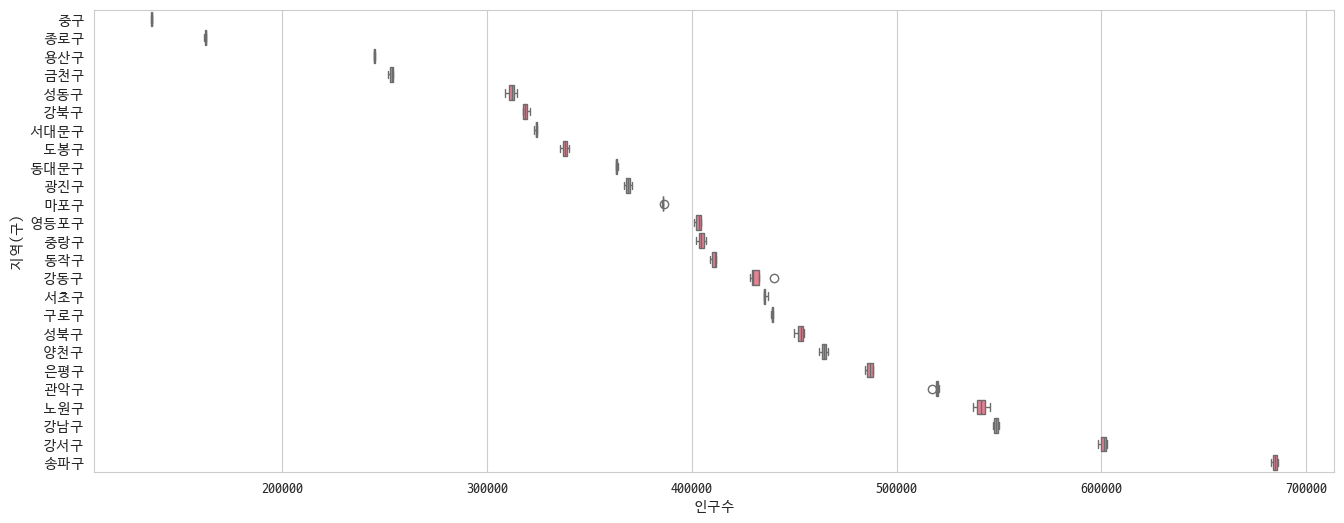

In [9]:
df = get_pop_filtered_df()
df = df[df['성별'] == '소계'].sort_values(by='인구수')

plt.figure(figsize=(16, 6))
sns.boxplot(data=df, y='지역(구)', x='인구수')

정규성을 띄기에, (조사)시점에 대하여 평균을 내어 사용하면 될 것 같다.

In [10]:
def get_pop_df() -> pd.DataFrame:
    df = get_pop_filtered_df()
    df = df[df['성별'] == '소계']
    del df['성별']
    return df.groupby('지역(구)').aggregate({'인구수': 'mean'}).sort_values(by='인구수').reset_index()

get_pop_df()

,지역(구),인구수
0,중구,"136,315.75"
1,종로구,"162,513.75"
2,용산구,"245,095.50"
3,금천구,"253,248.25"
4,성동구,"311,967.00"
5,강북구,"319,024.50"
6,서대문구,"324,042.00"
7,도봉구,"338,078.75"
8,동대문구,"363,291.25"
9,광진구,"368,859.25"


지역구 별 인구수를 지도에 표시해보자.

In [11]:
m = folium.Map(location=SEOUL_LOCATION, tiles='OpenStreetMap', zoom_start=11)

folium.Choropleth(
    name='인구수',
    data=get_pop_df(),
    columns=['지역(구)', '인구수'],
    geo_data=str(GEO_DATA_FILE),
    key_on='feature.properties.name',
    fill_color='YlOrRd',
).add_to(m)

m

## 데이터 취합

역별 승하차 통계 + 역별 지역구

In [12]:
def get_station_df():
    # 역명/사용일자별 승하차총승객수 합계만 남긴다.
    df = get_raw_df()
    df['승하차총승객수'] = df['승차총승객수'] + df['하차총승객수']
    df = df[['사용일자', '노선명', '역명', '승하차총승객수']]

    df_geoloc = get_geoloc_df()
    df = df.merge(df_geoloc, on=['역명', '노선명'], how='inner')

    # 역별 지역 정보만 남긴다.
    df_addr = get_addr_df()
    df_addr = df_addr.groupby(['역명']).aggregate({'지역(구)': 'first', '지역(동)': 'first'}).reset_index()

    return df.merge(df_addr, on='역명', how='inner').sort_values(by='승하차총승객수')

get_station_df().sort_values(by='역명')

,사용일자,노선명,역명,승하차총승객수,역지역,위도,경도,지역(구),지역(동)
49538,20190608,3호선,가락시장,"13,330.00",수도권,37.49,127.12,송파구,가락동
52142,20190617,3호선,가락시장,"22,685.00",수도권,37.49,127.12,송파구,가락동
39548,20190406,3호선,가락시장,"13,991.00",수도권,37.49,127.12,송파구,가락동
52957,20190619,3호선,가락시장,"19,004.00",수도권,37.49,127.12,송파구,가락동
53625,20190622,3호선,가락시장,"13,985.00",수도권,37.49,127.12,송파구,가락동
...,...,...,...,...,...,...,...,...,...
14148,20190215,경의선,효창공원앞,"6,269.00",수도권,37.54,126.96,용산구,효창동
52527,20190618,경의선,효창공원앞,"6,920.00",수도권,37.54,126.96,용산구,효창동
44158,20190421,경의선,효창공원앞,"8,084.00",수도권,37.54,126.96,용산구,효창동
34495,20190521,경의선,효창공원앞,"17,470.00",수도권,37.54,126.96,용산구,효창동


## "지역별 인구수와 승하차승객수가 관련 있는지 조사"

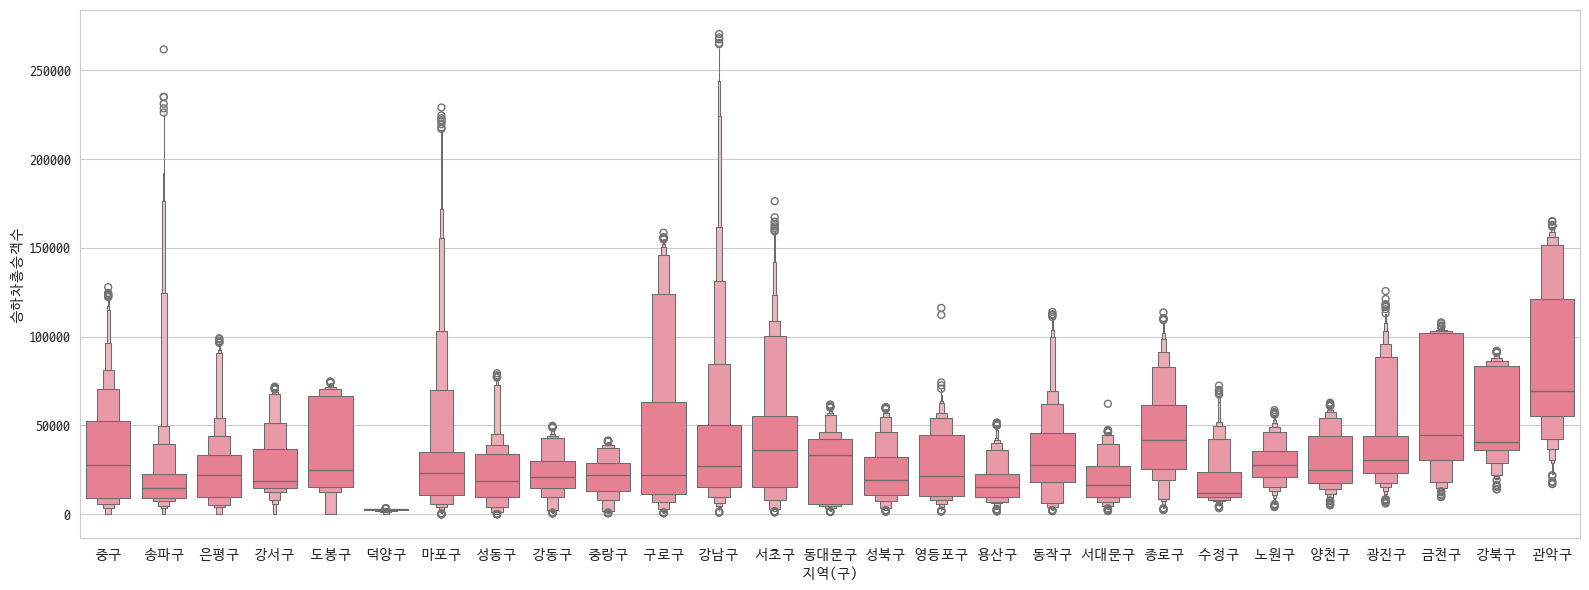

In [13]:
plt.figure(figsize=(16, 6))
sns.boxenplot(data=get_station_df(), x='지역(구)', y='승하차총승객수')
plt.tight_layout()

지도에 지역별 인구수와 지역별 승하차총승객수를 같이 출력해봅시다.

In [14]:
m = folium.Map(location=SEOUL_LOCATION, tiles='OpenStreetMap', zoom_start=11)

folium.Choropleth(
    name='인구수',
    data=get_pop_df(),
    columns=['지역(구)', '인구수'],
    geo_data=str(GEO_DATA_FILE),
    key_on='feature.properties.name',
    fill_color='OrRd',
    fill_opacity=0.5,
).add_to(m)

folium.plugins.HeatMap(
    name='승하차총승객수',
    data=get_station_df()[['위도', '경도', '승하차총승객수']].values.tolist(),
    radius=16,
    max_zoom=11,
).add_to(m)

folium.LayerControl(autoZIndex=False, collapsed=True).add_to(m)

m

이것만 봐서는 그다지 관련이 없어 보이네요...

![](../images/지역별인구수+승하차수.png)

그래도 혹시나 모르니, barplot 으로 출력해봅시다.

In [15]:
def get_local_passengers_df() -> pd.DataFrame:
    return get_station_df().groupby(['지역(구)']).aggregate({'승하차총승객수': 'sum'}).reset_index().sort_values('승하차총승객수')


get_local_passengers_df()

,지역(구),승하차총승객수
9,덕양구,"463,661.00"
14,서대문구,"17,341,569.00"
2,강북구,"19,943,001.00"
19,수정구,"19,983,495.00"
7,금천구,"20,682,698.00"
20,양천구,"26,814,768.00"
10,도봉구,"28,691,285.00"
26,중랑구,"34,358,013.00"
22,용산구,"36,521,026.00"
11,동대문구,"39,285,171.00"


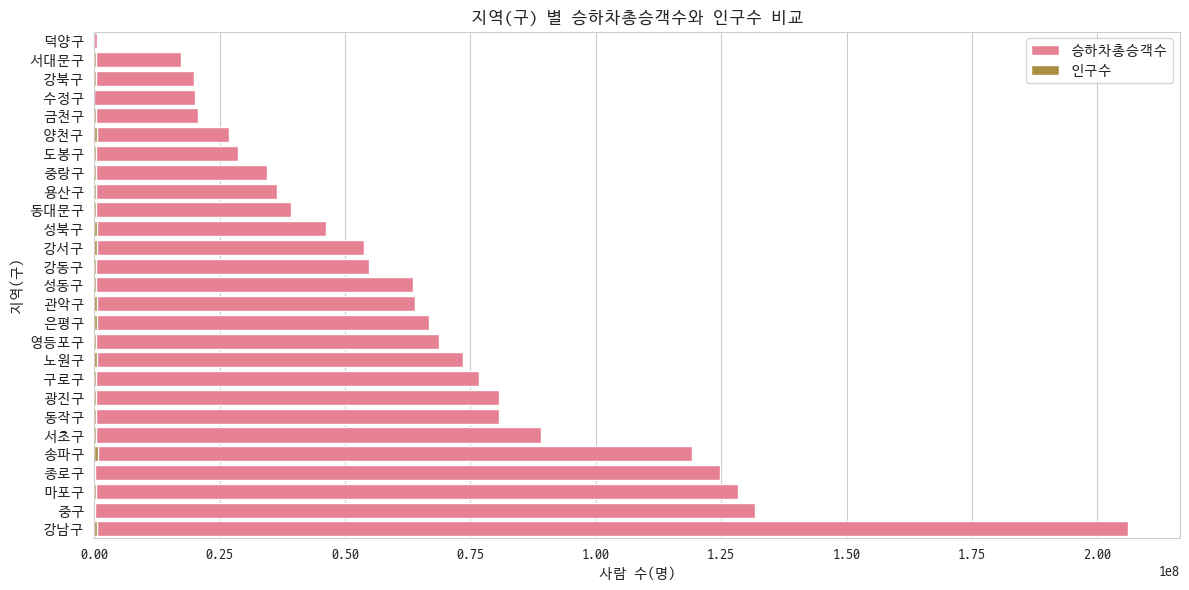

In [16]:
plt.figure(figsize=(12, 6))

sns.barplot(data=get_local_passengers_df(), y='지역(구)', x='승하차총승객수', label='승하차총승객수')
sns.barplot(data=get_pop_df(), y='지역(구)', x='인구수', label='인구수')

plt.title('지역(구) 별 승하차총승객수와 인구수 비교')
plt.xlabel('사람 수(명)')
plt.legend(loc='upper right')
plt.tight_layout()

승하차총승객수가 굉장히 기하급수적으로 늘어나서
인구수가 너무 작아서 안보이니, X축 스케일만 Log 스케일로 변경해봅시다.

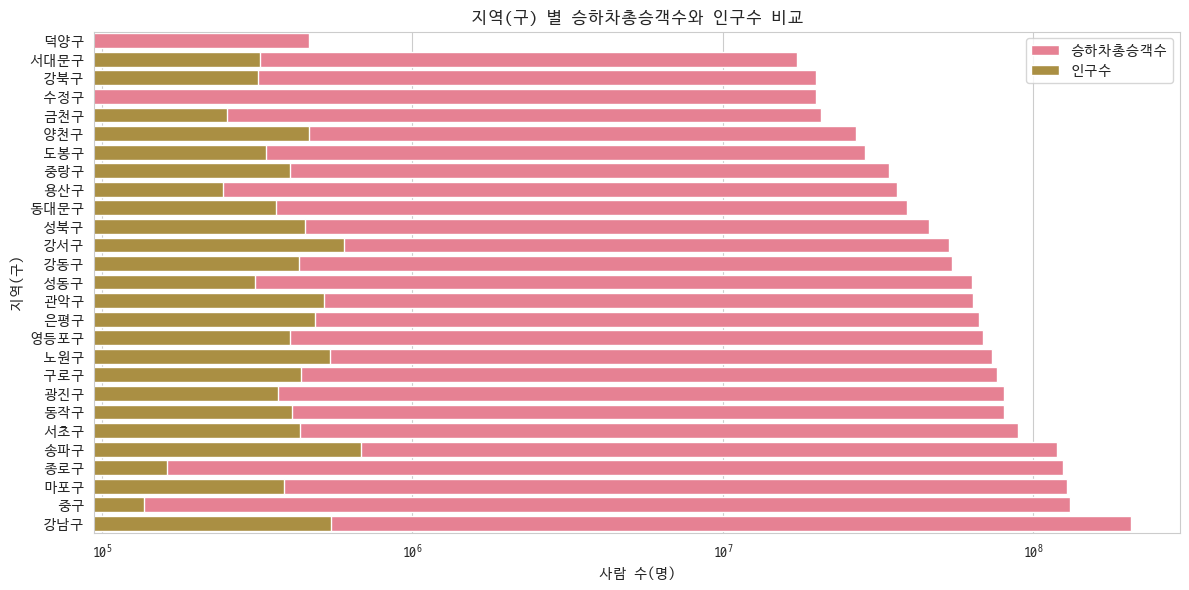

In [17]:
plt.figure(figsize=(12, 6))

sns.barplot(data=get_local_passengers_df(), y='지역(구)', x='승하차총승객수', label='승하차총승객수')
sns.barplot(data=get_pop_df(), y='지역(구)', x='인구수', label='인구수')

plt.title('지역(구) 별 승하차총승객수와 인구수 비교')
plt.xlabel('사람 수(명)')
plt.xscale('log')
plt.legend(loc='upper right')
plt.tight_layout()

스케일을 바꿔도 비교가 직관적인 것 같지는 않습니다.

이번에는 0.0~1.0 사이의 비율로 바꿔서 보도록 하겠습니다.

In [18]:
def get_local_passengers_ratio_df() -> pd.DataFrame:
    df = get_local_passengers_df()
    df['승하차총승객수'] = df['승하차총승객수'] / df['승하차총승객수'].sum()
    return df

def get_local_population_ratio_df() -> pd.DataFrame:
    df = get_pop_df()
    df['인구수'] = df['인구수'] / df['인구수'].sum()
    return df

get_local_passengers_ratio_df()

,지역(구),승하차총승객수
9,덕양구,0.00
14,서대문구,0.01
2,강북구,0.01
19,수정구,0.01
7,금천구,0.01
20,양천구,0.02
10,도봉구,0.02
26,중랑구,0.02
22,용산구,0.02
11,동대문구,0.02


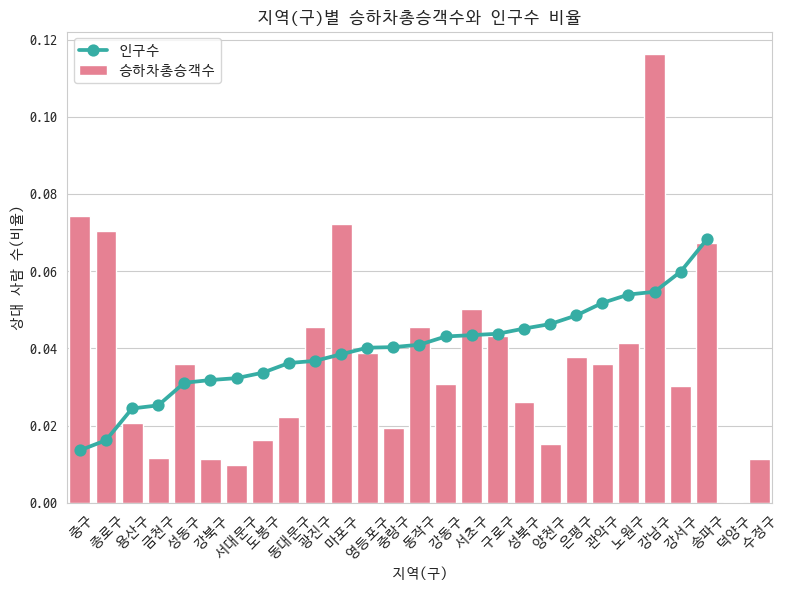

In [19]:
plt.figure(figsize=(8, 6))

sns.pointplot(data=get_local_population_ratio_df(), x='지역(구)', y='인구수', label='인구수', color=sns.color_palette('husl', 2)[1])
sns.barplot(data=get_local_passengers_ratio_df(), x='지역(구)', y='승하차총승객수', label='승하차총승객수')

plt.title('지역(구)별 승하차총승객수와 인구수 비율')
plt.xlabel('지역(구)')
plt.xticks(rotation=45)
plt.ylabel('상대 사람 수(비율)')
plt.legend(loc='upper left')
plt.tight_layout()

## 결론

* 단순 인구수는 승하차총승객수에 직접적인 연관은 없는 것으로 보인다.

* 인구수보다는 직장같은 유동인구를 유발하는 요인을 봐야할 듯 하다.